In [123]:
from transformers import VisionEncoderDecoderModel, GPT2TokenizerFast, AutoFeatureExtractor, \
                          AutoTokenizer, TrainingArguments, Trainer
from sklearn.feature_extraction.text import CountVectorizer
import cv2
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from datasets import Dataset
import torch
import numpy as np
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor, Resize, ToPILImage
import pandas as pd
import requests
from io import BytesIO

In [124]:
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    'google/vit-base-patch16-224-in21k',
    'distilgpt2',
)
model

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--vit-base-patch16-224-in21k/snapshots/7cbdb7ee3a6bcdf99dae654893f66519c480a0f8/config.json
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.26.1"
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--google--vit-base-patch16-224-in21k/snapshots/7cbdb7ee3a6bcdf99dae654893f66519c480a0f8/pytorch_model.bin
All model checkpoint weights were used when initializing ViTModel.

All t

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, 

In [125]:
type(model.encoder)

transformers.models.vit.modeling_vit.ViTModel

In [126]:
type(model.decoder)

transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel

In [127]:
total_param = 0
for param in model.parameters():
    total_param += torch.numel(param)
print(f'Our model has a combined {total_param:,} parameters')

Our model has a combined 182,485,248 parameters


In [128]:
gpt2_tokenizer = GPT2TokenizerFast.from_pretrained('distilgpt2')

loading file vocab.json from cache at /root/.cache/huggingface/hub/models--distilgpt2/snapshots/38cc92ec43315abd5136313225e95acc5986876c/vocab.json
loading file merges.txt from cache at /root/.cache/huggingface/hub/models--distilgpt2/snapshots/38cc92ec43315abd5136313225e95acc5986876c/merges.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilgpt2/snapshots/38cc92ec43315abd5136313225e95acc5986876c/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at None
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilgpt2/snapshots/38cc92ec43315abd5136313225e95acc5986876c/config.json
Model config GPT2Config {
  "_name_or_path": "distilgpt2",
  "_num_labels": 1,
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop"

In [129]:
IMAGE_PATH = 'data/flicker_images/images'
MIN_CAPTION, MAX_CAPTION = 10, 50
def load_captions_data(filename):
    with open(filename) as caption_file:
        caption_data = caption_file.readlines()
        caption_mapping = {}
        text_data = []

        for line in caption_data:
            line = line.rstrip('\n')
            img_name, caption = line.split(',', 1)
            img_name = os.path.join(IMAGE_PATH, img_name.strip())
            if img_name.endswith('jpg'):
                caption = caption.replace(' .', '').strip()
                if len(caption) < MIN_CAPTION or len(caption) > MAX_CAPTION:
                    continue
                text_data.append(caption)
                if img_name in caption_mapping:
                    caption_mapping[img_name].append(caption)
                else:
                    caption_mapping[img_name] = [caption]
        return caption_mapping, text_data

In [130]:
caption_mapping, text_data = load_captions_data('data/flicker_images/captions.txt')

In [131]:
list(caption_mapping.items())[:5]

[('data/flicker_images/images/1000268201_693b08cb0e.jpg',
  ['A girl going into a wooden building',
   'A little girl climbing into a wooden playhouse',
   'A little girl climbing the stairs to her playhouse']),
 ('data/flicker_images/images/1001773457_577c3a7d70.jpg',
  ['A black dog and a spotted dog are fighting',
   'Two dogs on pavement moving toward each other']),
 ('data/flicker_images/images/1003163366_44323f5815.jpg',
  ['A man lays on a bench while his dog sits by him',
   'A shirtless man lies on a park bench with his dog']),
 ('data/flicker_images/images/1007129816_e794419615.jpg',
  ['A man in an orange hat starring at something',
   'A man wears an orange hat and glasses']),
 ('data/flicker_images/images/1007320043_627395c3d8.jpg',
  ['A child playing on a rope net', 'A little girl climbing on red roping'])]

In [132]:
feature_extractor = AutoFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
feature_extractor

loading configuration file preprocessor_config.json from cache at /root/.cache/huggingface/hub/models--google--vit-base-patch16-224-in21k/snapshots/7cbdb7ee3a6bcdf99dae654893f66519c480a0f8/preprocessor_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--vit-base-patch16-224-in21k/snapshots/7cbdb7ee3a6bcdf99dae654893f66519c480a0f8/config.json
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.26.1"
}

/opt/conda/lib/python3.8/site-packages/transformers/m

ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [133]:
transforms = Compose([
    ToPILImage(),
    RandomResizedCrop(feature_extractor.size['height']),
    ToTensor(),
    Normalize(
      mean=feature_extractor.image_mean,
      std=feature_extractor.image_std,
    )
])

In [134]:
rows = []
for path, captions in caption_mapping.items():
    for caption in captions:
        rows.append({'path': path, 'caption': caption})
image_df = pd.DataFrame(rows)
image_df.shape

(19520, 2)

In [135]:
image_df.head()

,path,caption
0,data/flicker_images/images/1000268201_693b08cb...,A girl going into a wooden building
1,data/flicker_images/images/1000268201_693b08cb...,A little girl climbing into a wooden playhouse
2,data/flicker_images/images/1000268201_693b08cb...,A little girl climbing the stairs to her playh...
3,data/flicker_images/images/1001773457_577c3a7d...,A black dog and a spotted dog are fighting
4,data/flicker_images/images/1001773457_577c3a7d...,Two dogs on pavement moving toward each other


In [136]:
image_dataset = Dataset.from_pandas(image_df)
image_dataset

Dataset({
    features: ['path', 'caption'],
    num_rows: 19520
})

In [137]:
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token

In [138]:
def image_preprocess(examples):
    examples['pixel_values'] = [transforms(cv2.imread(path)) for path in examples['path']]
    tokenized = gpt2_tokenizer(
        examples['caption'],
        padding='max_length', 
        max_length=10,
        truncation=True,
    )['input_ids']
    examples['labels'] = [[l if l != gpt2_tokenizer.pad_token_id else -100 for l in t] for t in tokenized]
    del examples['path']
    del examples['caption']
    return examples

In [139]:
image_dataset = image_dataset.map(image_preprocess, batched=True)

Map:   0%|          | 0/19520 [00:00<?, ? examples/s]

In [140]:
image_dataset = image_dataset.train_test_split(test_size=0.1)

In [141]:
image_dataset

DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'labels'],
        num_rows: 17568
    })
    test: Dataset({
        features: ['pixel_values', 'labels'],
        num_rows: 1952
    })
})

In [142]:
model.config.pad_token = gpt2_tokenizer.pad_token
model.config.pad_token_id = gpt2_tokenizer.pad_token_id
model.config.decoder_start_token = gpt2_tokenizer.bos_token
model.config.decoder_start_token_id = gpt2_tokenizer.bos_token_id

In [143]:
for name, param in model.encoder.named_parameters():
    if 'encoder.layer.10' in name:
        break
    param.requires_grad = False

In [144]:
training_args = TrainingArguments(
    output_dir='v2_image_captioning',
    overwrite_output_dir=True,
    num_train_epochs=4,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    load_best_model_at_end=True,
    log_level='info',
    logging_steps=50,
    evaluation_strategy='epoch',
    save_strategy='epoch',
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=image_dataset['train'],
    eval_dataset=image_dataset['test'],
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [145]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 1952
  Batch size = 64


{'eval_loss': 5.125207901000977,
 'eval_runtime': 151.5103,
 'eval_samples_per_second': 12.884,
 'eval_steps_per_second': 0.205}

In [146]:
trainer.train()

/opt/conda/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 17568
  Num Epochs = 4
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 1100
  Number of trainable parameters = 110863872


Epoch,Training Loss,Validation Loss


TrainOutput(global_step=1100, training_loss=2.757006343494762, metrics={'train_runtime': 6468.1443, 'train_samples_per_second': 10.864, 'train_steps_per_second': 0.17, 'total_flos': 9.082279437784842e+18, 'train_loss': 2.757006343494762, 'epoch': 4.0})

In [147]:
trainer.evaluate()

{'eval_loss': 2.703036308288574,
 'eval_runtime': 149.6485,
 'eval_samples_per_second': 13.044,
 'eval_steps_per_second': 0.207,
 'epoch': 4.0}

In [148]:
trainer.save_model()

Saving model checkpoint to v2_image_captioning
Configuration saved in v2_image_captioning/config.json
Configuration saved in v2_image_captioning/generation_config.json
Model weights saved in v2_image_captioning/pytorch_model.bin


In [149]:
finetuned_model = VisionEncoderDecoderModel.from_pretrained('v2_image_captioning')

loading configuration file v2_image_captioning/config.json
Model config VisionEncoderDecoderConfig {
  "_commit_hash": null,
  "architectures": [
    "VisionEncoderDecoderModel"
  ],
  "decoder": {
    "_name_or_path": "distilgpt2",
    "_num_labels": 1,
    "activation_function": "gelu_new",
    "add_cross_attention": true,
    "architectures": [
      "GPT2LMHeadModel"
    ],
    "attn_pdrop": 0.1,
    "bad_words_ids": null,
    "begin_suppress_tokens": null,
    "bos_token_id": 50256,
    "chunk_size_feed_forward": 0,
    "cross_attention_hidden_size": null,
    "decoder_start_token_id": null,
    "diversity_penalty": 0.0,
    "do_sample": false,
    "early_stopping": false,
    "embd_pdrop": 0.1,
    "encoder_no_repeat_ngram_size": 0,
    "eos_token_id": 50256,
    "exponential_decay_length_penalty": null,
    "finetuning_task": null,
    "forced_bos_token_id": null,
    "forced_eos_token_id": null,
    "id2label": {
      "0": "LABEL_0"
    },
    "initializer_range": 0.02,
    "i

In [150]:
inference_transforms = Compose([
    ToPILImage(),
    Resize((feature_extractor.size['height'], feature_extractor.size['width'])),
    ToTensor(),
    Normalize(
        mean=feature_extractor.image_mean,
        std=feature_extractor.image_std,
    ),
])

In [151]:
def caption_image(m, path):
    if 'http' in path:
        response = requests.get(path)
        img = cv2.imdecode(np.frombuffer(BytesIO(response.content).read(), np.uint8), cv2.IMREAD_COLOR)
        image_matrix = inference_transforms(img).unsqueeze(0)
    else:
        img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        image_matrix = inference_transforms(img).unsqueeze(0)
    generated = m.generate(
        image_matrix,
        num_beams=3,
        max_length=15,
        early_stopping=True,
        do_sample=True,
        top_k=10,
        num_return_sequences=5
    )
    caption_options = [gpt2_tokenizer.decode(g, skip_special_tokens=True).strip() for g in generated]
    plt.imshow(img)
    return caption_options, generated, image_matrix

Generate config GenerationConfig {
  "decoder_start_token_id": 50256,
  "pad_token_id": 50256,
  "transformers_version": "4.26.1"
}

/opt/conda/lib/python3.8/site-packages/transformers/generation/utils.py:1186: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(


['A man and a woman are from gear"A man and a woman',
 'A girl in a red shirtballball-a-a-a',
 'A man in a red shirt andity in a red shirt a man',
 'A man and a woman sitbyaily of a man and a woman',
 'A group of people sit on stream Anyway them is is is is is']

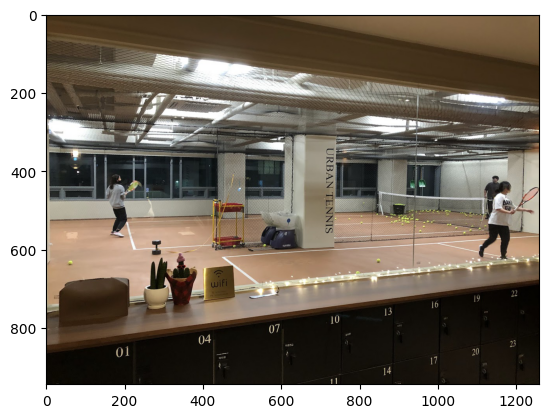

In [152]:
captions, generated, image_matrix = caption_image(
    finetuned_model,
    'data/flicker_images/urban_tennis.jpg'
)
captions

Generate config GenerationConfig {
  "decoder_start_token_id": 50256,
  "pad_token_id": 50256,
  "transformers_version": "4.26.1"
}



['A girl in a pink dress plays aqueNTEV elect�',
 'A girl is reading a book on twoturnesickrumiickrrod',
 'A girl in a red dress plays musical Asianmentmentmentmentment',
 'A girl in a pink dress is inB ALSO ALSO ALSO ALSO ALSO',
 'A girl in a pink dress is onulinELYELYELYELYELY']

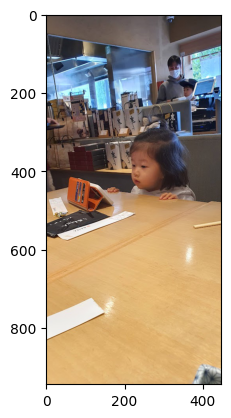

In [153]:
captions, generated, image_matrix = caption_image(
    finetuned_model,
    'data/flicker_images/jigyo_watching_cell_phone.jpg'
)
captions

Generate config GenerationConfig {
  "decoder_start_token_id": 50256,
  "pad_token_id": 50256,
  "transformers_version": "4.26.1"
}



['A man in fromGG�CTVAAaaaa',
 'A man stands overcraft.-uthor gloves are being handed out by a',
 'A man isCLASSIFIEDilibmentanwhilement of a group of people in',
 'A man in store ret catch also also jumping into the player playing a',
 'A man in PhotographueELY rootuppheisisisisis']

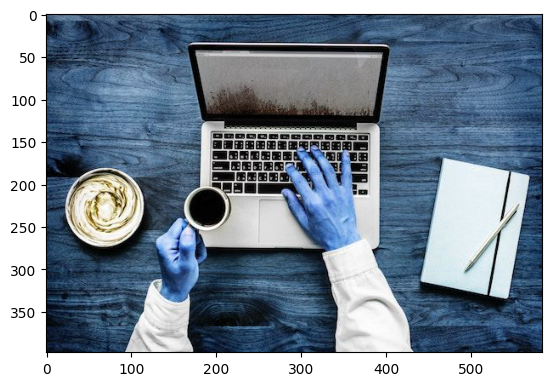

In [158]:
captions, generated, image_matrix = caption_image(
    finetuned_model,
    'https://53.fs1.hubspotusercontent-na1.net/hub/53/hubfs/parts-url.jpg?width=595&height=400&name=parts-url.jpg'
)
captions

In [154]:
vec = CountVectorizer(stop_words='english')
bag_of_words = vec.fit_transform(image_df['caption'])
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
sorted(words_freq, key=lambda x: x[1], reverse=True)[:20]

[('dog', 4077),
 ('man', 2847),
 ('boy', 1590),
 ('dogs', 1369),
 ('water', 1312),
 ('girl', 1304),
 ('black', 1214),
 ('people', 1149),
 ('playing', 1093),
 ('running', 1081),
 ('woman', 1072),
 ('white', 1063),
 ('young', 972),
 ('brown', 922),
 ('snow', 821),
 ('grass', 741),
 ('ball', 678),
 ('jumping', 678),
 ('red', 675),
 ('child', 661)]

Generate config GenerationConfig {
  "decoder_start_token_id": 50256,
  "pad_token_id": 50256,
  "transformers_version": "4.26.1"
}



['A brown dog is running through a fieldTV�A black and white',
 'A black and white dog runs through the(- (A black and white',
 'A brown dog is running through a field redesly a yard in a',
 'A black and white dog is running inlylyA black and a',
 'A black and white dog is running in Quan rate of the red and']

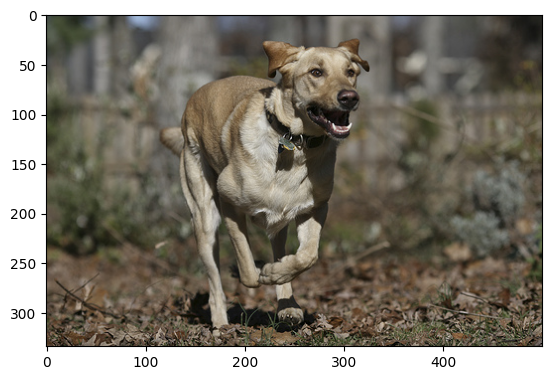

In [155]:
captions, generated, image_matrix = caption_image(
    finetuned_model,
    'data/flicker_images/images/3148647065_2d6cd88cf6.jpg'
)
captions

In [156]:
not_finetuned_model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    'google/vit-base-patch16-224-in21k',
    'distilgpt2',
)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--vit-base-patch16-224-in21k/snapshots/7cbdb7ee3a6bcdf99dae654893f66519c480a0f8/config.json
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.26.1"
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--google--vit-base-patch16-224-in21k/snapshots/7cbdb7ee3a6bcdf99dae654893f66519c480a0f8/pytorch_model.bin
All model checkpoint weights were used when initializing ViTModel.

All t

Generate config GenerationConfig {
  "transformers_version": "4.26.1"
}

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


['"I think it\'s a good idea to use a lot of',
 '.',
 '.',
 '.',
 'A new report by the Center for Responsive Politics shows that Republicans are']

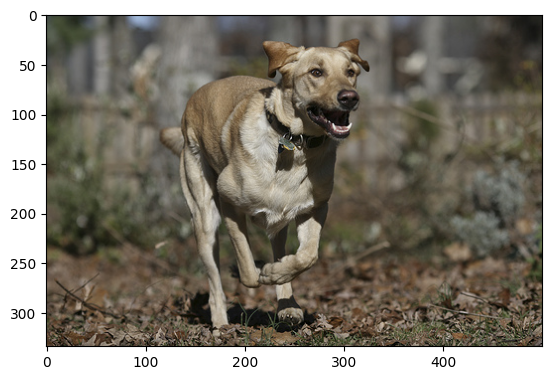

In [157]:
captions, generated, image_matrix = caption_image(
    not_finetuned_model,
    'data/flicker_images/images/3148647065_2d6cd88cf6.jpg'
)
captions